In [2]:
from operator import index

import pandas as pd
import numpy as np
from pandas.core.common import random_state
from pandas.core.interchange.from_dataframe import categorical_column_to_series
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tensorflow.python.ops.gen_dataset_ops import model_dataset
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [75]:
chunk_size = 100000

In [76]:
# Initialize variables for analysis
total_rows = 0
column_sums = None
column_squared_sums = None

In [77]:
# Step 3: Read the data in chunks
def read_csv_in_chunks(file_path, chunk_size):
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        yield chunk

In [78]:
# Step 4: Sample 20% of observation
labels = pd.read_csv('data/train_labels.csv')
sample_labels = labels.sample(frac=0.2, random_state=42)

In [79]:
# Read data
sampled_data = []
for chunk in read_csv_in_chunks('data/train_data.csv', chunk_size):
    merged_chunk = pd.merge(chunk, sample_labels, on='customer_ID', how='inner')
    sampled_data.append(merged_chunk)
    
# Combine all chunks into a single dataframe
development_sample = pd.concat(sampled_data, ignore_index=True)

# Save the development sample
development_sample.to_csv('data/development_sample.csv', index=False)

In [80]:
# load development_sample
data = []
for chunk in read_csv_in_chunks('data/development_sample.csv', chunk_size):
    data.append(chunk)

    

In [81]:
df = pd.concat(data, ignore_index=True)
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,NaN,NaN,0.008263,0.006609,0.007370,NaN,0.007171,0.005120,0.007513,0
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,NaN,NaN,0.001986,0.004050,0.000796,NaN,0.001802,0.002364,0.003987,0
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,NaN,NaN,0.009515,0.008757,0.009219,NaN,0.003134,0.001686,0.001265,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,NaN,NaN,0.002524,0.007841,0.007421,NaN,0.000728,0.003591,0.007998,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,NaN,NaN,0.003823,0.009599,0.006957,NaN,0.008746,0.007101,0.006658,0


In [82]:
def calculate_default_rate(data):
    # Initialize a DataFrame to store the results
    default_rates = pd.DataFrame(columns=["Category", "#Observations", "Default rate"])
    
    # Get the total number of unique customer IDs
    total_customers = len(data["customer_ID"].unique())
    
    # Calculate default rate for all applicants
    default_rate_all = data["target"].mean()
    default_rates.loc[0] = ["All applicants", total_customers, default_rate_all]
    
    # Calculate default rate for each category of historic data length
    for months in range(13, 0, -1):  # Iterate from 13 months to 1 month
        category_customers = data.groupby("customer_ID").size() == months  # Check if each customer has data for the specific number of months
        category_observations = category_customers.sum()  # Get the number of customers in this category
        category_data = data[data["customer_ID"].isin(category_customers[category_customers].index)]  # Filter data for the specific category
        default_rate_category = category_data["target"].mean()  # Calculate default rate for this category
        default_rates.loc[len(default_rates)] = [f"Applications with {months} months of historic data", category_observations, default_rate_category]
    
    return default_rates

# Call the function with your development_sample dataset
default_rates_data = calculate_default_rate(development_sample)

# Display the results
print(default_rates_data)

                                        Category  #Observations  Default rate
0                                 All applicants          91783      0.246498
1   Applications with 13 months of historic data          77348      0.229405
2   Applications with 12 months of historic data           2115      0.378723
3   Applications with 11 months of historic data           1159      0.440897
4   Applications with 10 months of historic data           1329      0.465764
5    Applications with 9 months of historic data           1278      0.435837
6    Applications with 8 months of historic data           1169      0.450813
7    Applications with 7 months of historic data           1046      0.414914
8    Applications with 6 months of historic data           1109      0.412985
9    Applications with 5 months of historic data            933      0.394427
10   Applications with 4 months of historic data            938      0.430704
11   Applications with 3 months of historic data           1158 

In [11]:
development_sample = pd.read_csv('data/development_sample.csv')

In [12]:
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [13]:
# Step 4: One-Hot Encoding
features = development_sample.drop([ 'S_2' ], axis=1).columns.to_list()
cat_col = [i for i in features if i.startswith('B_30')or i.startswith('B_38') or i.startswith('D_114') or
i.startswith('D_116')or i.startswith('D_117') or i.startswith('D_120') or i.startswith('D_126')
or i.startswith('D_63')or i.startswith('D_64')or i.startswith('D_66') or i.startswith('D_68')]
ind_col = ['customer_ID', 'target']
num_col = [col for col in features if col not in cat_col and col not in ind_col]
# Iterate over each categorical column in cat_col
for col in cat_col:
    # Create dummy variables for the current categorical column
    col_dummies = pd.get_dummies(development_sample[col], prefix=col)
    # Concatenate the dummy variables with the DataFrame
    development_sample = pd.concat([development_sample, col_dummies], axis=1)
    # Drop the original categorical column from the DataFrame
    development_sample.drop(col, axis=1, inplace=True)
    
# Update cat_col to include the new dummy variable columns
cat_col_updated = [col for col in development_sample.columns if col not in num_col]
# Print the updated cat_col list
print(cat_col_updated)
# Remove 'S_2' and 'customer_ID' from the updated cat_col list
cat_col = [col for col in cat_col_updated if col not in ['S_2', 'customer_ID' , 'target']]
# Print the updated cat_col list
print(cat_col)

['customer_ID', 'S_2', 'target', 'D_63_CL', 'D_63_CO', 'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ', 'D_64_-1', 'D_64_O', 'D_64_R', 'D_64_U', 'D_66_0.0', 'D_66_1.0', 'D_68_0.0', 'D_68_1.0', 'D_68_2.0', 'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0', 'B_30_0.0', 'B_30_1.0', 'B_30_2.0', 'B_38_1.0', 'B_38_2.0', 'B_38_3.0', 'B_38_4.0', 'B_38_5.0', 'B_38_6.0', 'B_38_7.0', 'D_114_0.0', 'D_114_1.0', 'D_116_0.0', 'D_116_1.0', 'D_117_-1.0', 'D_117_1.0', 'D_117_2.0', 'D_117_3.0', 'D_117_4.0', 'D_117_5.0', 'D_117_6.0', 'D_120_0.0', 'D_120_1.0', 'D_126_-1.0', 'D_126_0.0', 'D_126_1.0']
['D_63_CL', 'D_63_CO', 'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ', 'D_64_-1', 'D_64_O', 'D_64_R', 'D_64_U', 'D_66_0.0', 'D_66_1.0', 'D_68_0.0', 'D_68_1.0', 'D_68_2.0', 'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0', 'B_30_0.0', 'B_30_1.0', 'B_30_2.0', 'B_38_1.0', 'B_38_2.0', 'B_38_3.0', 'B_38_4.0', 'B_38_5.0', 'B_38_6.0', 'B_38_7.0', 'D_114_0.0', 'D_114_1.0', 'D_116_0.0', 'D_116_1.0', 'D_117_-1.0', 'D_117_1.0', 'D_117_

In [ ]:
df_encoded.to_csv('data/train_encoded_data.csv', index=False)

***USE THE BELOW CODE FOR QUESTION 6~***

In [28]:
# Step 6: Feature Engineering
df = pd.read_csv('data/train_encoded_data.csv')
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,0,1,0,0,0,0,0,0,0,1
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,0,1,0,0,0,0,0,0,0,1
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,0,1,0,0,1,0,0,0,0,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,0,1,0,0,1,0,0,0,0,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,0,1,0,0,1,0,0,0,0,0


In [31]:
features = df.drop([ 'S_2' ], axis=1).columns.to_list()
cat_col = [i for i in features if i.startswith('B_30')or i.startswith('B_38') or i.startswith('D_114') or
i.startswith('D_116')or i.startswith('D_117') or i.startswith('D_120') or i.startswith('D_126')
or i.startswith('D_63')or i.startswith('D_64')or i.startswith('D_66') or i.startswith('D_68')]
ind_col = ['customer_ID', 'target']
num_col = [col for col in features if col not in cat_col and col not in ind_col]

In [33]:
import pandas as pd

# Assuming df is already loaded and contains the necessary columns
# Ensure 'S_2' column is in datetime format
df['S_2'] = pd.to_datetime(df['S_2'])

# Define the numerical columns
num_col = [col for col in df.columns if col not in ['customer_ID', 'S_2', 'target']]

def calculate_numerical_statistics(df, time_period):
    last_date = df['S_2'].max()
    time_period_ago = last_date - pd.DateOffset(months=time_period)

    data_last_time_period = df[(df['S_2'] > time_period_ago) & (df['S_2'] <= last_date)]

    average_spend_last_time_period = data_last_time_period.groupby('customer_ID')[num_col].agg(['mean', 'min', 'max', 'sum'])
    average_spend_last_time_period.columns = [f'{col}_{agg}_{time_period}' for col, agg in average_spend_last_time_period.columns]

    return average_spend_last_time_period

# Calculate statistics for different time periods
average_spend_3_months = calculate_numerical_statistics(df, 3)
average_spend_6_months = calculate_numerical_statistics(df, 6)
average_spend_9_months = calculate_numerical_statistics(df, 9)
average_spend_12_months = calculate_numerical_statistics(df, 12)

final_numerical_df = pd.merge(average_spend_3_months, average_spend_6_months, on='customer_ID', how='inner')
final_numerical_df = pd.merge(final_numerical_df, average_spend_9_months, on='customer_ID', how='inner')
df_num_agg = pd.merge(final_numerical_df, average_spend_12_months, on='customer_ID', how='inner')

print(df_num_agg.head())

                                                    P_2_mean_3  P_2_min_3  \
customer_ID                                                                 
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f523...    0.447801   0.414444   
000445609ff2a39d2dd02484899affa5696210a95f6869f...    0.976846   0.974383   
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff...    0.638958   0.634894   
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab7040...    0.973429   0.963991   
00050d84c6d26e26cd2b18c3eed83d3130c270e2361470f...    0.993352   0.968914   

                                                    P_2_max_3  P_2_sum_3  \
customer_ID                                                                
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f523...   0.477116   1.343404   
000445609ff2a39d2dd02484899affa5696210a95f6869f...   0.978897   2.930539   
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff...   0.642295   1.916874   
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab7040...   0.980221   2.920287   
0005

In [42]:
df_num_agg.to_csv('data/df_num_agg.csv', index=True)

In [35]:
# categorical data
df[['customer_ID','S_2'] + cat_col].to_csv('data/df_categorical.csv')

In [39]:
# 
def calculate_categorical_statistics(df, time_period):
    last_date = df['S_2'].max()
    time_period_ago = last_date - pd.DateOffset(months=time_period)

    data_last_time_period = df[(df['S_2'] > time_period_ago) & (df['S_2'] <= last_date)]

    response_rate = data_last_time_period.groupby('customer_ID')[cat_col].agg(['mean', 'max'])
    response_rate.columns = [f'{col}_{agg}_{time_period}' for col, agg in response_rate.columns]
    return response_rate

df_cat_six = calculate_categorical_statistics(df, 6)
df_cat_twelve = calculate_categorical_statistics(df, 12)

df_cat_agg = pd.merge(df_cat_six, df_cat_twelve, on='customer_ID', how='inner')

print(df_cat_agg)
print(df_cat_agg.shape)

                                                    B_30_0.0_mean_6  \
customer_ID                                                           
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f523...         0.500000   
000445609ff2a39d2dd02484899affa5696210a95f6869f...         1.000000   
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff...         0.833333   
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab7040...         1.000000   
00050d84c6d26e26cd2b18c3eed83d3130c270e2361470f...         1.000000   
...                                                             ...   
fffe2bc02423407e33a607660caeed076d713d8a5ad3232...         0.166667   
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd...         0.333333   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...         1.000000   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...         1.000000   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...         1.000000   

                                                    B_30_0.0_max_6  \
custom

In [40]:
df_cat_agg.to_csv('data/df_cat_agg.csv', index=True)

In [41]:
df_cat_agg = pd.read_csv('data/df_cat_agg.csv')
df_cat_agg.head()

,customer_ID,B_30_0.0_mean_6,B_30_0.0_max_6,B_30_1.0_mean_6,B_30_1.0_max_6,B_30_2.0_mean_6,B_30_2.0_max_6,B_30_nan_mean_6,B_30_nan_max_6,B_38_1.0_mean_6,...,D_68_3.0_mean_12,D_68_3.0_max_12,D_68_4.0_mean_12,D_68_4.0_max_12,D_68_5.0_mean_12,D_68_5.0_max_12,D_68_6.0_mean_12,D_68_6.0_max_12,D_68_nan_mean_12,D_68_nan_max_12
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.500000,1,0.166667,1,0.333333,1,0.0,0,0.0,...,0.333333,1,0.0,0,0.000000,0,0.000000,0,0.083333,1
1,000445609ff2a39d2dd02484899affa5696210a95f6869...,1.000000,1,0.000000,0,0.000000,0,0.0,0,1.0,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0
2,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,0.833333,1,0.166667,1,0.000000,0,0.0,0,0.0,...,0.000000,0,0.0,0,1.000000,1,0.000000,0,0.000000,0
3,0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704...,1.000000,1,0.000000,0,0.000000,0,0.0,0,0.0,...,0.000000,0,0.0,0,0.583333,1,0.416667,1,0.000000,0
4,00050d84c6d26e26cd2b18c3eed83d3130c270e2361470...,1.000000,1,0.000000,0,0.000000,0,0.0,0,0.0,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0


In [43]:
# Create a DataFrame to store the final feature-engineered data
df_feature_engineered_agg = df_num_agg.merge(df_cat_agg, on='customer_ID', how='inner')
df_feature_engineered_agg.head()

,customer_ID,P_2_mean_3,P_2_min_3,P_2_max_3,P_2_sum_3,D_39_mean_3,D_39_min_3,D_39_max_3,D_39_sum_3,B_1_mean_3,...,D_68_3.0_mean_12_y,D_68_3.0_max_12_y,D_68_4.0_mean_12_y,D_68_4.0_max_12_y,D_68_5.0_mean_12_y,D_68_5.0_max_12_y,D_68_6.0_mean_12_y,D_68_6.0_max_12_y,D_68_nan_mean_12_y,D_68_nan_max_12_y
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.447801,0.414444,0.477116,1.343404,0.014288,0.000467,0.035885,0.042865,0.069795,...,0.333333,1,0.0,0,0.000000,0,0.000000,0,0.083333,1
1,000445609ff2a39d2dd02484899affa5696210a95f6869...,0.976846,0.974383,0.978897,2.930539,0.002024,0.001221,0.002629,0.006072,0.008831,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0
2,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,0.638958,0.634894,0.642295,1.916874,0.574667,0.415254,0.685210,1.724002,0.431032,...,0.000000,0,0.0,0,1.000000,1,0.000000,0,0.000000,0
3,0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704...,0.973429,0.963991,0.980221,2.920287,0.268469,0.009431,0.470704,0.805407,0.023506,...,0.000000,0,0.0,0,0.583333,1,0.416667,1,0.000000,0
4,00050d84c6d26e26cd2b18c3eed83d3130c270e2361470...,0.993352,0.968914,1.006598,2.980056,0.092158,0.005624,0.150871,0.276473,0.040335,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0


In [44]:
df_feature_engineered_agg.to_csv('data/df_feature_engineered_agg.csv', index=True)

In [45]:
df_feature_engineered_agg.columns

Index(['customer_ID', 'P_2_mean_3', 'P_2_min_3', 'P_2_max_3', 'P_2_sum_3',
       'D_39_mean_3', 'D_39_min_3', 'D_39_max_3', 'D_39_sum_3', 'B_1_mean_3',
       ...
       'D_68_3.0_mean_12_y', 'D_68_3.0_max_12_y', 'D_68_4.0_mean_12_y',
       'D_68_4.0_max_12_y', 'D_68_5.0_mean_12_y', 'D_68_5.0_max_12_y',
       'D_68_6.0_mean_12_y', 'D_68_6.0_max_12_y', 'D_68_nan_mean_12_y',
       'D_68_nan_max_12_y'],
      dtype='object', length=3933)

In [4]:
df = pd.read_csv('data/df_feature_engineered_agg.csv', index_col=0)
# df = df_feature_engineered_agg
df.head()

,customer_ID,P_2_mean_3,P_2_min_3,P_2_max_3,P_2_sum_3,D_39_mean_3,D_39_min_3,D_39_max_3,D_39_sum_3,B_1_mean_3,...,D_68_3.0_mean_12_y,D_68_3.0_max_12_y,D_68_4.0_mean_12_y,D_68_4.0_max_12_y,D_68_5.0_mean_12_y,D_68_5.0_max_12_y,D_68_6.0_mean_12_y,D_68_6.0_max_12_y,D_68_nan_mean_12_y,D_68_nan_max_12_y
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.447801,0.414444,0.477116,1.343404,0.014288,0.000467,0.035885,0.042865,0.069795,...,0.333333,1,0.0,0,0.000000,0,0.000000,0,0.083333,1
1,000445609ff2a39d2dd02484899affa5696210a95f6869...,0.976846,0.974383,0.978897,2.930539,0.002024,0.001221,0.002629,0.006072,0.008831,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0
2,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,0.638958,0.634894,0.642295,1.916874,0.574667,0.415254,0.685210,1.724002,0.431032,...,0.000000,0,0.0,0,1.000000,1,0.000000,0,0.000000,0
3,0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704...,0.973429,0.963991,0.980221,2.920287,0.268469,0.009431,0.470704,0.805407,0.023506,...,0.000000,0,0.0,0,0.583333,1,0.416667,1,0.000000,0
4,00050d84c6d26e26cd2b18c3eed83d3130c270e2361470...,0.993352,0.968914,1.006598,2.980056,0.092158,0.005624,0.150871,0.276473,0.040335,...,0.000000,0,0.0,0,0.000000,0,1.000000,1,0.000000,0


In [5]:
label = pd.read_csv('data/train_labels.csv')
df_ = pd.merge(df, label, on='customer_ID', how='inner')

In [6]:
# Step 7; Train-test split
# Use a random seed of 42 for the split.
# Split the data into features and target
X = df_.drop(columns=['customer_ID', 'target'])
y = df_['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



In [7]:
# save train and test data as csv
X_train.to_csv('data/X_train.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
X_test1.to_csv('data/X_test1.csv', index=False)
y_test1.to_csv('data/y_test1.csv', index=False)
X_test2.to_csv('data/X_test2.csv', index=False)
y_test2.to_csv('data/y_test2.csv', index=False)

In [8]:
# Step 8: Calculate feature importance using XGBoost

# Load the training data
# X_train = pd.read_csv('data/X_train.csv')
# y_train = pd.read_csv('data/y_train.csv')

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier()

# Fit the model
xgb_model.fit(X_train, y_train)

# # Plot the feature importance
# plot_importance(xgb_model)

# Save the feature importance
feature_importance = xgb_model.feature_importances_
np.save('feature_importance.npy', feature_importance)

# Display the feature importance
print("Feature importance:")
print(feature_importance)

Feature importance:
[0.17870915 0.01835535 0.00311878 ... 0.         0.         0.        ]


In [9]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [10]:
feature_importance_df.to_csv('data/feature_importance.csv', index=False)

In [11]:
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.005]
important_features

,Feature,Importance
0,P_2_mean_3,0.178709
16,R_1_mean_3,0.018654
1,P_2_min_3,0.018355
9,B_1_min_3,0.013687
8,B_1_mean_3,0.011424
3003,B_18_sum_12,0.007714
13,B_2_min_3,0.006070
125,B_11_min_3,0.005633


In [12]:
# Run XGB applying parameters 300 trees, 0.5 as learning rate, maximum depth of trees is 4, uses 50% of observation to build each tree, uses 50% of features to build each tree, and assigns a weight of 5 to default observations. 
# Save the model as 'xgb_model_important_features'
# Initialize the XGBClassifier
xgb_model_important_features = xgb.XGBClassifier(n_estimators=300, learning_rate=0.5, max_depth=4, subsample=0.5, colsample_bytree=0.5, scale_pos_weight=5, random_state=71)

# Fit the model
xgb_model_important_features.fit(X_train, y_train)

# Calculate the feature importance
feature_importance_parameter_model = xgb_model_important_features.feature_importances_



In [13]:
# Save the feature importance
feature_importance_parameter_model_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_parameter_model
})
feature_importance_parameter_model_df = feature_importance_parameter_model_df.sort_values(by='Importance', ascending=False)

feature_importance_parameter_model_df.to_csv('data/feature_importance_parameter_model_initial.csv', index=False)
feature_importance_parameter_model_df = feature_importance_parameter_model_df[feature_importance_parameter_model_df['Importance'] > 0.005]

feature_importance_parameter_model_df.to_csv('data/feature_importance_parameter_model.csv', index=False)

feature_importance_parameter_model_df

,Feature,Importance
2784,P_2_mean_12,0.139109
0,P_2_mean_3,0.027470
125,B_11_min_3,0.012099
1,P_2_min_3,0.011516
15,B_2_sum_3,0.010975
2835,D_45_sum_12,0.006811
96,B_9_mean_3,0.006378
8,B_1_mean_3,0.005516


In [16]:
feature_importance_concat_df = pd.concat([feature_importance_parameter_model_df, important_features])
# drop duplicated rows
feature_importance_concat_df = feature_importance_concat_df.drop_duplicates(subset='Feature', keep='first')
feature_importance_concat_df


,Feature,Importance
2784,P_2_mean_12,0.139109
0,P_2_mean_3,0.027470
125,B_11_min_3,0.012099
1,P_2_min_3,0.011516
15,B_2_sum_3,0.010975
2835,D_45_sum_12,0.006811
96,B_9_mean_3,0.006378
8,B_1_mean_3,0.005516
16,R_1_mean_3,0.018654
9,B_1_min_3,0.013687


In [17]:
feature_importance_concat_df.to_csv('data/feature_importance_concat.csv', index=False)

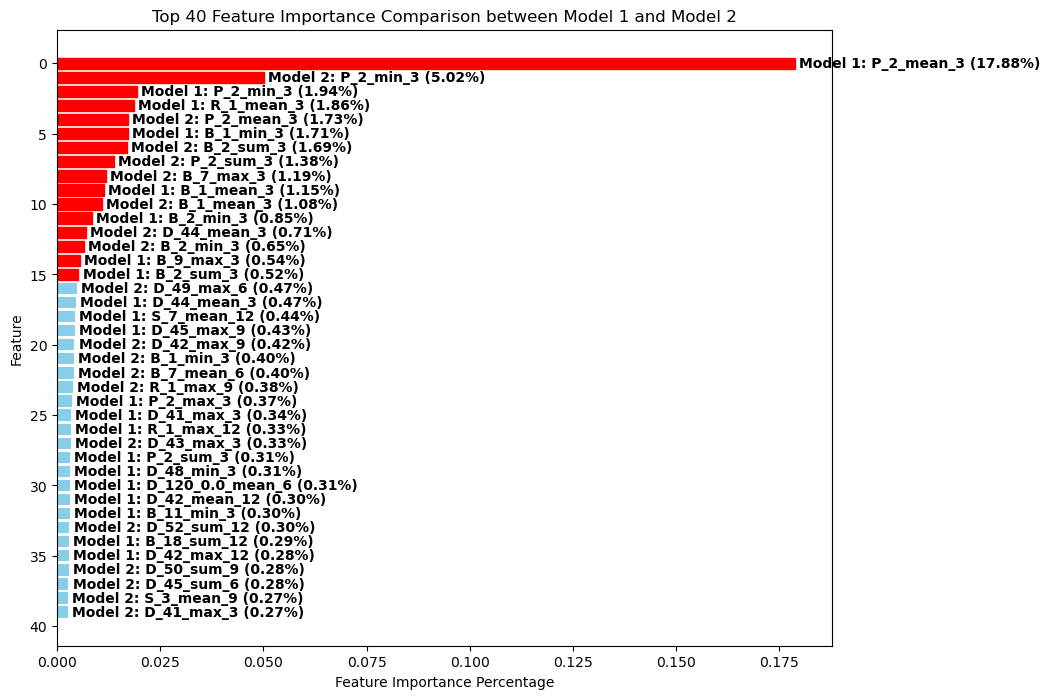

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load feature importance from the first model
feature_importance_initial_df1 = pd.read_csv('data/model1_feature_importance_initial.csv')
feature_importance_initial_df1['Model'] = 'Model 1'

# Load feature importance from the second model
feature_importance_initial_df2 = pd.read_csv('data/feature_importance_parameter_model_initial.csv')
feature_importance_initial_df2['Model'] = 'Model 2'

# Concatenate both DataFrames
combined_feature_importance_initial = pd.concat([feature_importance_initial_df1, feature_importance_initial_df2])

# Sort the combined DataFrame by importance values in descending order
combined_feature_importance_initial.sort_values(by='Importance', ascending=False, inplace=True)

# Filter the top 30 features
top_30_features = combined_feature_importance_initial.head(40)

# Plotting
plt.figure(figsize=(10, 8))

# Plot horizontal bars
bars = plt.barh(range(len(top_30_features)), top_30_features['Importance'], color='skyblue')

# Add labels for model name and percentage
for i, bar in enumerate(bars):
    feature = top_30_features.iloc[i]['Feature']
    importance = top_30_features.iloc[i]['Importance']
    model = top_30_features.iloc[i]['Model']
    if importance > 0.005:
        bar.set_color('red')
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f'{model}: {feature} ({importance:.2%})', va='center', ha='left', fontsize=10, color='black', weight='bold')

# Add labels and title
plt.xlabel('Feature Importance Percentage')
plt.ylabel('Feature')
plt.title('Top 40 Feature Importance Comparison between Model 1 and Model 2')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top

# Show plot
plt.show()


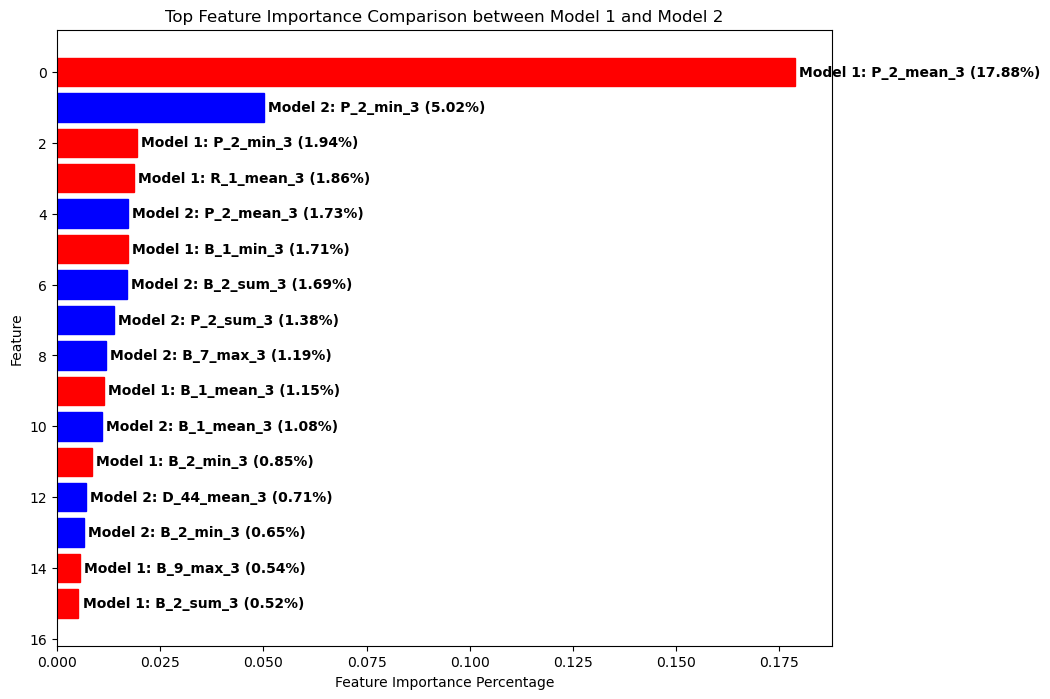

In [16]:
import pandas as pd
import matplotlib.pyplot as plt


# Sort the combined DataFrame by importance values in descending order
feature_importance_concat_df.sort_values(by='Importance', ascending=False, inplace=True)

# Filter the top features
top_features = feature_importance_concat_df.head(60)

# Plotting
plt.figure(figsize=(10, 8))

# Plot horizontal bars
bars = plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')

# Add labels for model name and percentage
for i, bar in enumerate(bars):
    feature = top_features.iloc[i]['Feature']
    importance = top_features.iloc[i]['Importance']
    model = top_features.iloc[i]['Model']
    if importance > 0.005:
        if model == 'Model 1':
            bar.set_color('red')
        else:
            bar.set_color('blue')
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f'{model}: {feature} ({importance:.2%})', va='center', ha='left', fontsize=10, color='black', weight='bold')

# Add labels and title
plt.xlabel('Feature Importance Percentage')
plt.ylabel('Feature')
plt.title('Top Feature Importance Comparison between Model 1 and Model 2')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top

# Show plot
plt.show()



In [8]:
feature_importance_concat_df

,Feature,Importance
0,P_2,0.250095
1,B_7,0.124635
2,B_38_2.0,0.091958
3,D_44,0.057968
4,D_42,0.034543
5,B_9,0.033858
6,D_45,0.029030
7,B_22,0.028504
8,S_3,0.025349
9,B_3,0.024330


In [33]:
### step 9: When to resume training process
# Load the training data, applying important features calculated by step 8
# Load the training data, applying important features calculated by step 8
X_train = pd.read_csv('data/X_train.csv')
feature_importance_concat_df = pd.read_csv('data/feature_importance_concat.csv')
X_train = X_train[feature_importance_concat_df['Feature']]
y_train = pd.read_csv('data/y_train.csv')

X_test1 = pd.read_csv('data/X_test1.csv')
X_test1 = X_test1[feature_importance_concat_df['Feature']]
y_test1 = pd.read_csv('data/y_test1.csv')

X_test2 = pd.read_csv('data/X_test2.csv')
X_test2 = X_test2[feature_importance_concat_df['Feature']]
y_test2 = pd.read_csv('data/y_test2.csv')

In [19]:
Grid_Search_Results = pd.DataFrame(columns = ["Number of Trees", "Learning Rate (LR)", 'Subsample', '% Features', 'Weight of Default',"AUC Train", "AUC Test 1", "AUC Test 2"])

In [20]:
Counter = 0
for n_trees in [50, 100, 300]:
    for lr in [0.01, 0.1]:
        for subsample in [0.5, 0.8]:
            for colsample in [0.5, 1.0]:
                for weight in [1, 5, 10]:
                    xgb_instance = xgb.XGBClassifier(n_estimators= n_trees, learning_rate = lr,subsample=subsample, colsample_bytree=colsample, scale_pos_weight=weight)                    
                    model = xgb_instance.fit(X_train, y_train)
                    
                    Grid_Search_Results.loc[Counter,"Number of Trees"] = n_trees
                    Grid_Search_Results.loc[Counter,"Learning Rate (LR)"] = lr
                    Grid_Search_Results.loc[Counter,"Subsample"] = subsample
                    Grid_Search_Results.loc[Counter,"% Features"] = colsample
                    Grid_Search_Results.loc[Counter,"Weight of Default"] = weight
                    
                    Grid_Search_Results.loc[Counter,"AUC Train"] = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
                    Grid_Search_Results.loc[Counter,"AUC Test 1"] = roc_auc_score(y_test1, model.predict_proba(X_test1)[:,1])
                    Grid_Search_Results.loc[Counter,"AUC Test 2"] = roc_auc_score(y_test2, model.predict_proba(X_test2)[:,1])

                    Counter += 1
                    print('complete iteration:', Counter)
print('Grid search completed')
Grid_Search_Results.to_csv("output/Grid_Search_Results.csv")

complete iteration: 1
complete iteration: 2
complete iteration: 3
complete iteration: 4
complete iteration: 5
complete iteration: 6
complete iteration: 7
complete iteration: 8
complete iteration: 9
complete iteration: 10
complete iteration: 11
complete iteration: 12
complete iteration: 13
complete iteration: 14
complete iteration: 15
complete iteration: 16
complete iteration: 17
complete iteration: 18
complete iteration: 19
complete iteration: 20
complete iteration: 21
complete iteration: 22
complete iteration: 23
complete iteration: 24
complete iteration: 25
complete iteration: 26
complete iteration: 27
complete iteration: 28
complete iteration: 29
complete iteration: 30
complete iteration: 31
complete iteration: 32
complete iteration: 33
complete iteration: 34
complete iteration: 35
complete iteration: 36
complete iteration: 37
complete iteration: 38
complete iteration: 39
complete iteration: 40
complete iteration: 41
complete iteration: 42
complete iteration: 43
complete iteration: 

In [21]:
Grid_Search_Results = pd.read_csv('output/Grid_Search_Results.csv')
Grid_Search_Results

,Unnamed: 0,Number of Trees,Learning Rate (LR),Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2
0,0,50,0.01,0.5,0.5,1,0.942191,0.941011,0.937612
1,1,50,0.01,0.5,0.5,5,0.941583,0.940178,0.936684
2,2,50,0.01,0.5,0.5,10,0.941236,0.940032,0.936256
3,3,50,0.01,0.5,1.0,1,0.943098,0.940714,0.938166
4,4,50,0.01,0.5,1.0,5,0.942138,0.939905,0.936933
...,...,...,...,...,...,...,...,...,...
67,67,300,0.10,0.8,0.5,5,0.969840,0.941760,0.938748
68,68,300,0.10,0.8,0.5,10,0.967230,0.940642,0.938339
69,69,300,0.10,0.8,1.0,1,0.973695,0.941699,0.938551
70,70,300,0.10,0.8,1.0,5,0.972552,0.941118,0.938339


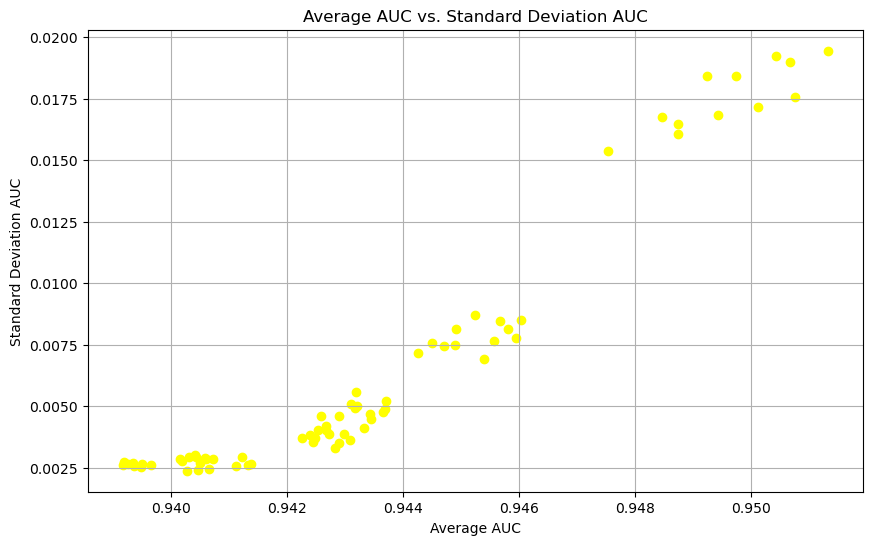

In [22]:
## Calculate average and standard deviation of AUC across three samples (train and two tests)
Grid_Search_Results['Average AUC'] = Grid_Search_Results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].mean(axis=1)
Grid_Search_Results['Standard Deviation AUC'] = Grid_Search_Results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].std(axis=1)

## Create a scatter plot of average AUC and standard deviation AUC
plt.figure(figsize=(10, 6))
plt.scatter(Grid_Search_Results['Average AUC'], Grid_Search_Results['Standard Deviation AUC'], color='yellow')
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation AUC')
plt.title('Average AUC vs. Standard Deviation AUC')
plt.grid(True)
plt.show()








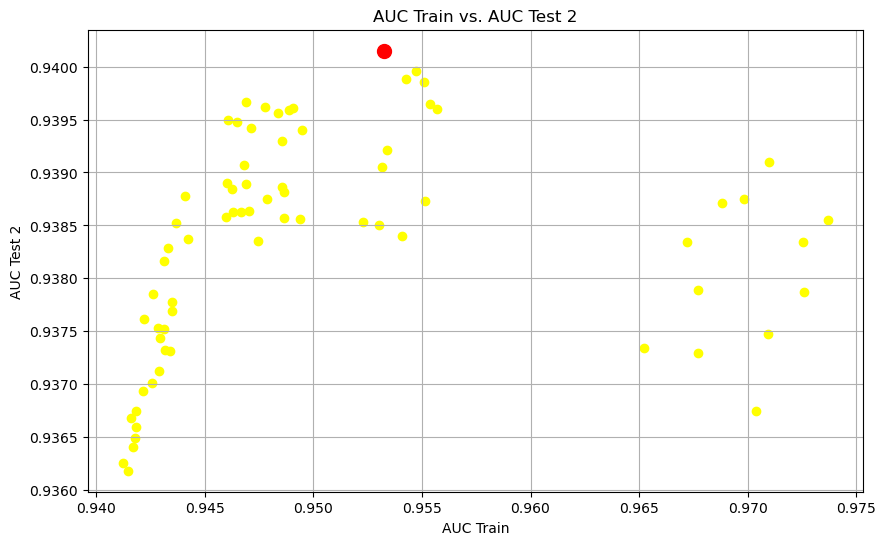

In [23]:
# X-Axis is AUC of train sample and Y-Axis is AUC of Test 2 sample
plt.figure(figsize=(10, 6))
plt.scatter(Grid_Search_Results['AUC Train'], Grid_Search_Results['AUC Test 2'], color='yellow')

# Find
highest_index = Grid_Search_Results['AUC Test 2'].idxmax()
plt.scatter(Grid_Search_Results.loc[highest_index, 'AUC Train'], Grid_Search_Results.loc[highest_index, 'AUC Test 2'], color='red', s=100, label='Highest AUC Test 2')
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('AUC Train vs. AUC Test 2')
plt.grid(True)
plt.show()

In [24]:
Grid_Search_Results

,Unnamed: 0,Number of Trees,Learning Rate (LR),Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Standard Deviation AUC
0,0,50,0.01,0.5,0.5,1,0.942191,0.941011,0.937612,0.940271,0.002377
1,1,50,0.01,0.5,0.5,5,0.941583,0.940178,0.936684,0.939482,0.002522
2,2,50,0.01,0.5,0.5,10,0.941236,0.940032,0.936256,0.939175,0.002599
3,3,50,0.01,0.5,1.0,1,0.943098,0.940714,0.938166,0.940659,0.002466
4,4,50,0.01,0.5,1.0,5,0.942138,0.939905,0.936933,0.939659,0.002612
...,...,...,...,...,...,...,...,...,...,...,...
67,67,300,0.10,0.8,0.5,5,0.969840,0.941760,0.938748,0.950116,0.017147
68,68,300,0.10,0.8,0.5,10,0.967230,0.940642,0.938339,0.948737,0.016057
69,69,300,0.10,0.8,1.0,1,0.973695,0.941699,0.938551,0.951315,0.019445
70,70,300,0.10,0.8,1.0,5,0.972552,0.941118,0.938339,0.950670,0.019002


In [25]:
# Find the best parameters
best_parameters = Grid_Search_Results.iloc[Grid_Search_Results['Average AUC'].idxmax()]
print(best_parameters)
best_model = xgb.XGBClassifier(
    n_estimators=int(best_parameters['Number of Trees']),
    learning_rate=best_parameters['Learning Rate (LR)'],
    subsample=best_parameters['Subsample'],
    colsample_bytree=best_parameters['% Features'],
    scale_pos_weight=best_parameters['Weight of Default']
)

Unnamed: 0                 69.000000
Number of Trees           300.000000
Learning Rate (LR)          0.100000
Subsample                   0.800000
% Features                  1.000000
Weight of Default           1.000000
AUC Train                   0.973695
AUC Test 1                  0.941699
AUC Test 2                  0.938551
Average AUC                 0.951315
Standard Deviation AUC      0.019445
Name: 69, dtype: float64


In [26]:
print(best_parameters)
print(best_model)

Unnamed: 0                 69.000000
Number of Trees           300.000000
Learning Rate (LR)          0.100000
Subsample                   0.800000
% Features                  1.000000
Weight of Default           1.000000
AUC Train                   0.973695
AUC Test 1                  0.941699
AUC Test 2                  0.938551
Average AUC                 0.951315
Standard Deviation AUC      0.019445
Name: 69, dtype: float64
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_

In [27]:
# Train the best model
best_xgb_model = xgb.XGBClassifier(
    n_estimators=int(best_parameters['Number of Trees']),
    learning_rate=best_parameters['Learning Rate (LR)'],
    subsample=best_parameters['Subsample'],
    colsample_bytree=best_parameters['% Features'],
    scale_pos_weight=best_parameters['Weight of Default']
)

best_xgb_model.fit(X_train, y_train)

# Save the best model
best_xgb_model.save_model('best_xgb_model.json')

In [28]:
# Load the model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('best_xgb_model.json')

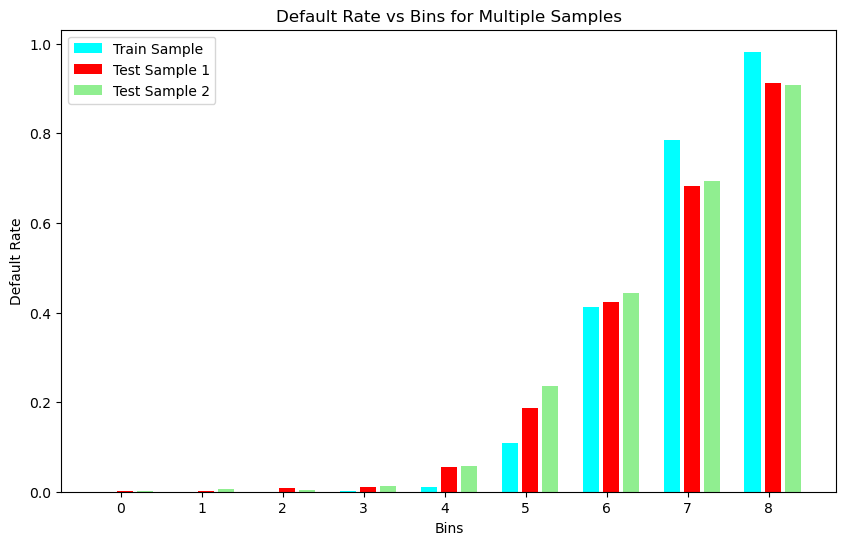

AUC on Train Sample: 0.9736945591621177
AUC on Test Sample 1: 0.9416988620505647
AUC on Test Sample 2: 0.9385512245872505


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def calculate_auc(model, X, y):
    """Calculate AUC for the given model and data."""
    return roc_auc_score(y, model.predict_proba(X)[:, 1])

def create_score_bins(model, X, q=9):
    """Create score bins for the given model and data."""
    return pd.qcut(model.predict_proba(X)[:, 1], q=q, labels=False, duplicates='drop')

def calculate_default_rate(bins, y):
    """Calculate default rate for each bin."""
    return [y[bins == i].mean() for i in range(bins.max() + 1)]

def plot_rank_ordering(train_default_rate, test1_default_rate, test2_default_rate, bin_labels=None):
    """Plot rank ordering of default rates for multiple samples."""
    plt.figure(figsize=(10, 6))
    
    # Convert default rates to numpy arrays
    train_default_rate = np.array(train_default_rate)
    test1_default_rate = np.array(test1_default_rate)
    test2_default_rate = np.array(test2_default_rate)
    
    # Check if all default rate arrays have the same length
    if len(train_default_rate) != len(test1_default_rate) or len(train_default_rate) != len(test2_default_rate):
        raise ValueError("All default rate arrays must have the same length.")
    
    # Set bin labels or default to range
    if bin_labels is None:
        bin_labels = np.arange(len(train_default_rate))  # Default bin labels if not provided
    
    # Ensure bin_labels matches the length of the default rates
    if len(bin_labels) != len(train_default_rate):
        raise ValueError("Bin labels must have the same length as the default rate arrays.")
    
    # Index for bar chart
    index = np.arange(len(bin_labels))
    bar_width = 0.2
    gap = 0.05
    
    # Plot the bar chart for each sample
    plt.bar(index, train_default_rate, bar_width, color='cyan', label='Train Sample')
    plt.bar(index + bar_width + gap, test1_default_rate, bar_width, color='red', label='Test Sample 1')
    plt.bar(index + 2 * (bar_width + gap), test2_default_rate, bar_width, color='lightgreen', label='Test Sample 2')
    
    # Add labels and title
    plt.xlabel('Bins')
    plt.ylabel('Default Rate')
    plt.title('Default Rate vs Bins for Multiple Samples')
    
    # Show bin labels on x-axis
    plt.xticks(index + bar_width, bin_labels)
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()

# Calculate AUC for each sample
train_auc = calculate_auc(loaded_model, X_train, y_train)
test1_auc = calculate_auc(loaded_model, X_test1, y_test1)
test2_auc = calculate_auc(loaded_model, X_test2, y_test2)

# Create score bins for the train sample
train_bins = create_score_bins(loaded_model, X_train)

# Apply the same thresholds to test samples
test1_bins = create_score_bins(loaded_model, X_test1, q=len(np.unique(train_bins)))
test2_bins = create_score_bins(loaded_model, X_test2, q=len(np.unique(train_bins)))

# Calculate default rate in each bin for each sample
train_default_rate = calculate_default_rate(train_bins, y_train)
test1_default_rate = calculate_default_rate(test1_bins, y_test1)
test2_default_rate = calculate_default_rate(test2_bins, y_test2)

train_default_rate = np.array(train_default_rate)
test1_default_rate = np.array(test1_default_rate)
test2_default_rate = np.array(test2_default_rate)

train_default_rate = np.nan_to_num(train_default_rate, nan=0)
test1_default_rate = np.nan_to_num(test1_default_rate, nan=0)
test2_default_rate = np.nan_to_num(test2_default_rate, nan=0)

train_default_rate = train_default_rate.tolist()
train_default_rate = [item for sublist in train_default_rate for item in sublist]
test1_default_rate = test1_default_rate.tolist()
test1_default_rate = [item for sublist in test1_default_rate for item in sublist]
test2_default_rate = test2_default_rate.tolist()
test2_default_rate = [item for sublist in test2_default_rate for item in sublist]

bin_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8']

# Plot the rank orderings in a bar chart
plot_rank_ordering(train_default_rate, test1_default_rate, test2_default_rate, bin_labels)

# Display AUC of the model on each sample
print("AUC on Train Sample:", train_auc)
print("AUC on Test Sample 1:", test1_auc)
print("AUC on Test Sample 2:", test2_auc)

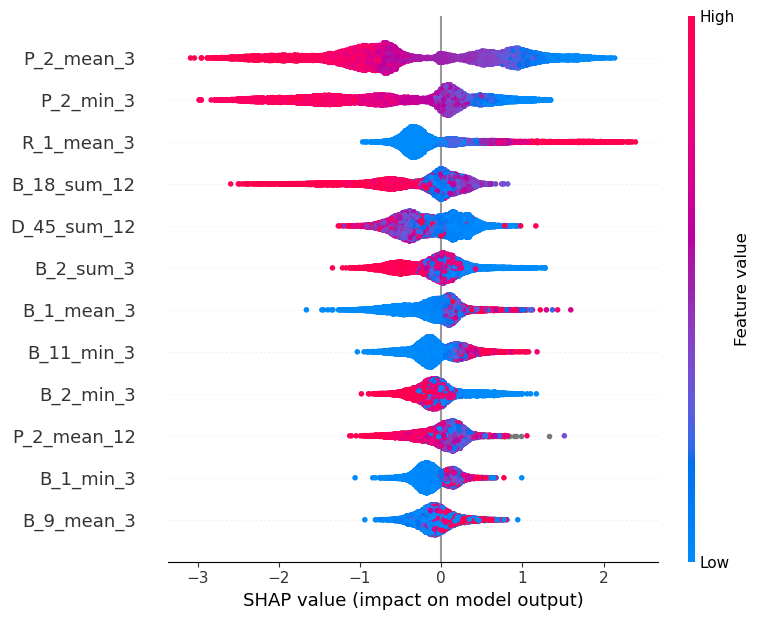

In [34]:

import shap
# # Load the test 2 data
# X_test2 = pd.read_csv('data/X_test2.csv')
# Initialize the TreeExplainer with the final XGBoost model
explainer = shap.Explainer(loaded_model)
# Calculate SHAP values for the Test 2 sample
shap_values = explainer.shap_values(X_test2)
# Create the beeswarm plot for the SHAP values
shap.summary_plot(shap_values, X_test2, plot_type="dot")

# Show the plot
plt.show()


In [36]:
import shap

# 1. Get SHAP values
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(X_train)  # Assuming X_train is the training data

# 2. Identify top 5 features
top_features_idx = np.argsort(-np.abs(shap_values.mean(0)))[:5]
top_features = [X_train.columns[i] for i in top_features_idx]

# 3. Calculate summary statistics for top 5 features
summary_stats = pd.DataFrame(columns=["Feature", "Min", "1st Percentile", "5th Percentile", "Median", "95th Percentile", "99th Percentile", "Max", "Mean", "% Missing"])

for feature in top_features:
    feature_values = X_train[feature]
    summary_stats.loc[len(summary_stats)] = [
        feature,
        feature_values.min(),
        np.percentile(feature_values, 1),
        np.percentile(feature_values, 5),
        feature_values.median(),
        np.percentile(feature_values, 95),
        np.percentile(feature_values, 99),
        feature_values.max(),
        feature_values.mean(),
        (feature_values.isnull().sum() / len(feature_values)) * 100
    ]

# 4. Create table
summary_stats.to_excel("output/top_features_summary_statistics.xlsx", index=False)
print(summary_stats)

       Feature       Min  1st Percentile  5th Percentile    Median  \
0    P_2_min_3 -0.420581             NaN             NaN  0.659588   
1   P_2_mean_3 -0.374501             NaN             NaN  0.682820   
2  B_18_sum_12  0.000254        0.062067        0.712115  6.633906   
3  D_45_sum_12  0.000000        0.011653        0.061756  1.877898   
4   B_1_mean_3 -0.244147        0.002226        0.003950  0.035982   

   95th Percentile  99th Percentile        Max      Mean  % Missing  
0              NaN              NaN   1.009947  0.614300   0.611692  
1              NaN              NaN   1.009947  0.638800   0.611692  
2        12.065556        12.075986  12.096039  6.672133   0.000000  
3         9.111494        11.852506  19.104476  2.833911   0.000000  
4         0.646200         1.050152   1.323839  0.136794   0.000000  


In [37]:
explainer = shap.Explainer(loaded_model,X_test2)
shap_values = explainer(X_test2)

100%|===================| 13747/13768 [03:17<00:00]        

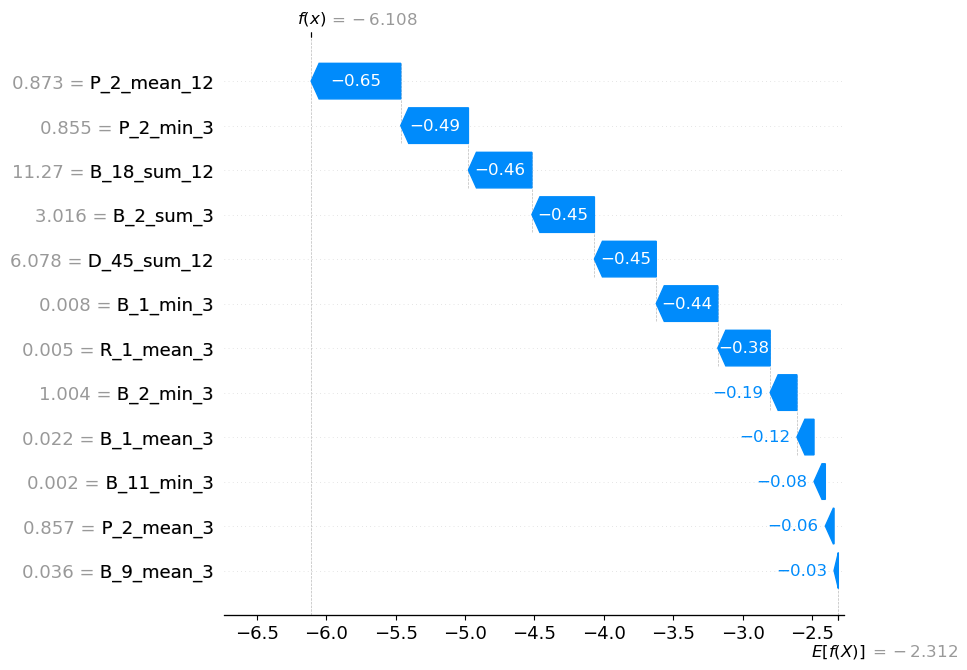

In [38]:
shap.plots.waterfall(shap_values[10], max_display=20)

In [39]:
# step 10: Neural Network
# Data Preprocessing
outliers = pd.DataFrame(columns = ['Feature', 'p1', 'p99'])

counter = 1
for col in X_train.columns:
    p1 = X_train[col].quantile(0.01)
    p99 = X_train[col].quantile(0.99)
    outliers.loc[counter] = [col, p1, p99]
    counter += 1
    print('complete iteration:', counter)
print('----Calculation Complete----')
outliers.to_csv('output/outliers.csv', index=False)



complete iteration: 2
complete iteration: 3
complete iteration: 4
complete iteration: 5
complete iteration: 6
complete iteration: 7
complete iteration: 8
complete iteration: 9
complete iteration: 10
complete iteration: 11
complete iteration: 12
complete iteration: 13
----Calculation Complete----


In [40]:
# replace outliers with p1 and p99
X_train = X_train.clip(lower = X_train.quantile(0.01), upper = X_train.quantile(0.99), axis = 1)
X_test1 = X_test1.clip(lower = X_train.quantile(0.01), upper = X_train.quantile(0.99), axis = 1)
X_test2 = X_test2.clip(lower = X_train.quantile(0.01), upper = X_train.quantile(0.99), axis = 1)

In [41]:
# feature scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test1_scaled = pd.DataFrame(scaler.transform(X_test1), columns = X_train.columns)
X_test2_scaled = pd.DataFrame(scaler.transform(X_test2), columns = X_train.columns)


In [42]:
# fill missing values with 0
print('Number of missing values in X_train:', X_train_scaled.isnull().sum().sum())
print('Number of missing values in X_test1:', X_test1_scaled.isnull().sum().sum())
print('Number of missing values in X_test2:', X_test2_scaled.isnull().sum().sum())


Number of missing values in X_train: 1129
Number of missing values in X_test1: 259
Number of missing values in X_test2: 267


In [43]:
X_train_scaled.fillna(0, inplace=True)
X_test1_scaled.fillna(0, inplace=True)
X_test2_scaled.fillna(0, inplace=True)

In [44]:
# Check the number of missing values again
print('Number of missing values in X_train:', X_train_scaled.isnull().sum().sum())
print('Number of missing values in X_test1:', X_test1_scaled.isnull().sum().sum())
print('Number of missing values in X_test2:', X_test2_scaled.isnull().sum().sum())

Number of missing values in X_train: 0
Number of missing values in X_test1: 0
Number of missing values in X_test2: 0


In [45]:
X_train_scaled

,P_2_mean_12,P_2_mean_3,B_11_min_3,P_2_min_3,B_2_sum_3,D_45_sum_12,B_9_mean_3,B_1_mean_3,R_1_mean_3,B_1_min_3,B_18_sum_12,B_2_min_3
0,-0.319332,-0.100086,-0.154200,-0.650809,-1.397350,-0.860916,1.102522,-0.150938,-0.410863,-0.070301,-0.811811,-1.172024
1,-0.681675,-0.746734,1.198938,-0.655672,-1.346659,0.260600,-0.743760,1.238736,-0.406592,1.321831,-0.774957,-1.214813
2,-1.677220,-1.718166,0.374681,-1.643313,-1.416897,-0.899848,1.760266,0.393126,1.492090,0.491907,-1.597462,-1.216151
3,0.013539,0.059923,-0.502704,0.124724,0.584513,0.297366,-0.746385,-0.595677,-0.422977,-0.552944,1.104496,0.685589
4,-0.361979,-0.269794,-0.509591,-0.178081,0.904216,1.931807,-0.749971,-0.606298,-0.428528,-0.563172,0.311416,0.676677
...,...,...,...,...,...,...,...,...,...,...,...,...
64243,1.107543,1.003705,-0.498854,0.880030,0.585047,0.584522,-0.740974,-0.602401,-0.421076,-0.561018,0.790492,0.681646
64244,0.089343,0.497109,-0.181660,0.540434,-1.412472,0.044526,1.448286,-0.153812,-0.426669,-0.065095,-0.814568,-1.184948
64245,-0.044371,0.000000,-0.499780,0.000000,0.213664,3.197444,-0.746381,-0.520850,-0.424694,-0.485862,1.142722,-1.265988
64246,-0.106826,-0.196194,-0.510634,-0.165413,1.077220,-0.974903,-0.607141,-0.592630,-0.418504,-0.539091,-0.229418,1.136758


In [46]:
X_train_scaled.to_csv('data/X_train_scaled.csv', index=False)
X_test1_scaled.to_csv('data/X_test1_scaled.csv', index=False)
X_test2_scaled.to_csv('data/X_test2_scaled.csv', index=False)

In [47]:
# load data for nn
X_train_scaled = pd.read_csv('data/X_train_scaled.csv')
X_test1_scaled = pd.read_csv('data/X_test1_scaled.csv')
X_test2_scaled = pd.read_csv('data/X_test2_scaled.csv')

y_train = pd.read_csv('data/y_train.csv')
y_test1 = pd.read_csv('data/y_test1.csv')
y_test2 = pd.read_csv('data/y_test2.csv')

In [48]:
# build neural network
nn_grid_search_result = pd.DataFrame(columns = ["#HL", "#Nodes", "ActivationFunction", "Dropout", "BatchSize", "AUC_Train", "AUC_Test1", "AUC_Test2"])

Counter = 0
for hl in [2,4]:
    for nodes in [4,6]:
        for activate_function in ["relu", "tanh"]:
            for dropout in [0, 0.5]:
                for batch_size in [100, 10000]:
                    model = Sequential()
                    model.add(Dense(nodes, input_dim=X_train_scaled.shape[1], activation=activate_function))
                    model.add(Dropout(dropout))
                    for i in range(hl - 1):
                        model.add(Dense(nodes, activation=activate_function))
                        model.add(Dropout(dropout))
                    model.add(Dense(1, activation='sigmoid'))
                    model.compile(optimizer=Adam(), loss=BinaryCrossentropy())
                    model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=20)
                    
                    nn_grid_search_result.loc[Counter, "#HL"] = hl
                    nn_grid_search_result.loc[Counter, "#Nodes"] = nodes
                    nn_grid_search_result.loc[Counter, "ActivationFunction"] = activate_function
                    nn_grid_search_result.loc[Counter, "Dropout"] = dropout
                    nn_grid_search_result.loc[Counter, "BatchSize"] = batch_size
                    nn_grid_search_result.loc[Counter, "AUC_Train"] = roc_auc_score(y_train, model.predict(X_train_scaled))
                    nn_grid_search_result.loc[Counter, "AUC_Test1"] = roc_auc_score(y_test1, model.predict(X_test1_scaled))
                    nn_grid_search_result.loc[Counter, "AUC_Test2"] = roc_auc_score(y_test2, model.predict(X_test2_scaled))
                    
                    Counter += 1

print('Grid search completed')
nn_grid_search_result.to_csv('output/nn_grid_search_result.csv')
                    
                    

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 542us/step - loss: 0.6049
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 0.2802
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.2785
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - loss: 0.2771
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.2772
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 0.2740
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - loss: 0.2718
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.2743
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.2752
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 0.2756
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 0.2752
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 0.2718
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - loss: 0.2716
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2729
Epoch 15/20
643/643 ━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7577  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7255 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.6959
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6684 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6420 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6176 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5948 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5722 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5524 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5315 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5135 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4960 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4802 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4661 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4508 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - loss: 0.6253
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.4708
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.4545
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.4439
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.4421
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.4396
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.4412
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.4410
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.4364
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.4409
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.4372
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.4410
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 0.4391
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - loss: 0.4363
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8833  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8525 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8267 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7990 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7796 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7667 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7485 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7292 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7189 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7070 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6985 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6874 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6839 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6744 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6678 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - loss: 0.4789
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.2855
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.2832
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.2830
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.2826
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.2806
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 0.2729
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.2824
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.2783
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - loss: 0.2759
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.2779
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 0.2778
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 0.2767
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 0.2771
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3578  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2923 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2245 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1593 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0961 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0293 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9706 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9146 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8596 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8094 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7599 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7167 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6745 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6400 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6091 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - loss: 0.7180
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 0.4086
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.3808
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 0.3687
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 0.3632
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.3551
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.3576
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 0.3593
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - loss: 0.3560
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.3552
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.3529
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.3543
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.3547
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 0.3547
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7244  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7056 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6879 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6737 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6550 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6446 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6352 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6262 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6143 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6074 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5976 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5902 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5841 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5798 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5713 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - loss: 0.4466
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 0.2763
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.2694
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 0.2731
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.2749
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.2729
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 0.2716
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 0.2707
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.2698
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.2699
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.2714
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.2719
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.2700
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 0.2690
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9277  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8804 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8386 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7987 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7673 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7408 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7167 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6955 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6790 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6624 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6511 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6388 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6283 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6202 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6104 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - loss: 0.5798
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.4101
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.3856
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.3762
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 0.3732
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.3626
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 0.3680
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.3681
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.3681
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.3690
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 0.3691
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.3672
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.3697
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 0.3696
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7193  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6921 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6527 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6404 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6212 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6079 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5975 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5832 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5691 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5647 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5490 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5441 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5325 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5271 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 0.3836
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.2838
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 0.2821
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 0.2798
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.2794
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.2775
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.2732
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.2753
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 0.2773
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.2717
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.2749
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.2742
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.2768
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 0.2707
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2154  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1341 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0552 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9749 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8960 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8187 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7454 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6803 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6218 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5702 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5291 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4948 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4655 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4426 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4241 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 0.5853
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.3664
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 0.3489
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - loss: 0.3432
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.3347
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.3337
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.3300
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 0.3329
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.3309
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.3288
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.3301
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.3348
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 0.3231
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.3250
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0365  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9648 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9091 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8512 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8008 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7541 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7125 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6486 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6248 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6033 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5857 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5728 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5556 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5421 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - loss: 0.4325
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.3082
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.2941
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.2871
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2841
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.2826
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.2753
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.2767
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.2793
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 0.2771
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 0.2762
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 0.2756
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 0.2747
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.2754
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8488  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8074 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7730 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7472 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7265 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7094 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6974 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6865 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6773 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6682 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6596 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6524
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6450 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6372 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6291 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 0.6347
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5519
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.5316
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.5284
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.5284
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 0.5260
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 0.5312
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.5278
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 0.5281
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.5271
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - loss: 0.5246
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.5265
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.5283
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.5235
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7158
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7074 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7022 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6916 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6862
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6770
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6731
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6638 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6567 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6502 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6449 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6395 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6356 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6321 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6277 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - loss: 0.4251
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.2975
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.2820
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 0.2776
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.2771
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 0.2744
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.2725
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.2722
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 0.2715
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 0.2736
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 0.2733
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.2743
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 0.2748
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 0.2772
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8393  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8029 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7703 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7399 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7128 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6887 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6667 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6475 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6302 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6138 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5990 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5858 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5734 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5609 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5487 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - loss: 0.6088
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 0.4555
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 0.4279
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.4109
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 0.4079
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.4003
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.3970
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.3982
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.3965
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 0.3926
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.3959
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.3906
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.3927
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - loss: 0.3923
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6963  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6825 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6722 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6606 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6553 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6403 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6349 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6293 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6216 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6144 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6117 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6048 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5965 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5951 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5868 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - loss: 0.4711
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 0.2770
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.2764
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 0.2761
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 0.2762
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.2686
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.2718
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - loss: 0.2691
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2725
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 0.2719
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 0.2692
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.2699
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.2724
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 0.2722
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6885  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6672 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6497 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6322 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6126 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5899 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5639 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5369 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5096 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4818 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4566 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4334 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4119 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3950 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3816 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - loss: 0.6617
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.5162
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4802
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.4631
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.4453
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 0.4338
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.4322
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.4240
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.4226
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 0.4214
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 0.4219
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - loss: 0.4229
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - loss: 0.4189
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - loss: 0.4227
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7883  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7559 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7375 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7164 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6975 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6850 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6770 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6582 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6496 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6387 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6285 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6222 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6098 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6050 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6035 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 640us/step - loss: 0.3715
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 0.2836
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.2754
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 0.2782
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.2756
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 0.2757
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 0.2715
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - loss: 0.2746
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.2748
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.2722
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 0.2714
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.2715
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 0.2790
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 0.2697
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7355  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7087 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6823 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6571 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6332 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6101 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5894 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5704 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5512 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5347 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5182 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5043 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4898 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4771 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4643 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - loss: 0.6681
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.4440
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.3945
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.3795
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 0.3664
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 0.3644
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.3611
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 0.3618
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - loss: 0.3553
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.3577
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 0.3532
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.3567
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.3541
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.3503
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7392  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7202 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7051 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6906 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6744 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6637 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6503 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6409 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6296 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6204 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6097 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6003 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5907 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5817 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5699 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

In [49]:
nn_grid_search_result = pd.read_csv('output/nn_grid_search_result.csv', index_col=0)
nn_grid_search_result

,#HL,#Nodes,ActivationFunction,Dropout,BatchSize,AUC_Train,AUC_Test1,AUC_Test2
0,2,4,relu,0.0,100,0.938030,0.939961,0.936207
1,2,4,relu,0.0,10000,0.899502,0.901711,0.903354
2,2,4,relu,0.5,100,0.936686,0.938521,0.934323
3,2,4,relu,0.5,10000,0.812889,0.814870,0.811759
4,2,4,tanh,0.0,100,0.937497,0.939370,0.935426
5,2,4,tanh,0.0,10000,0.792524,0.793077,0.788306
6,2,4,tanh,0.5,100,0.935965,0.938119,0.933083
7,2,4,tanh,0.5,10000,0.887881,0.891833,0.885297
8,2,6,relu,0.0,100,0.938893,0.940714,0.937412
9,2,6,relu,0.0,10000,0.904605,0.906329,0.898492


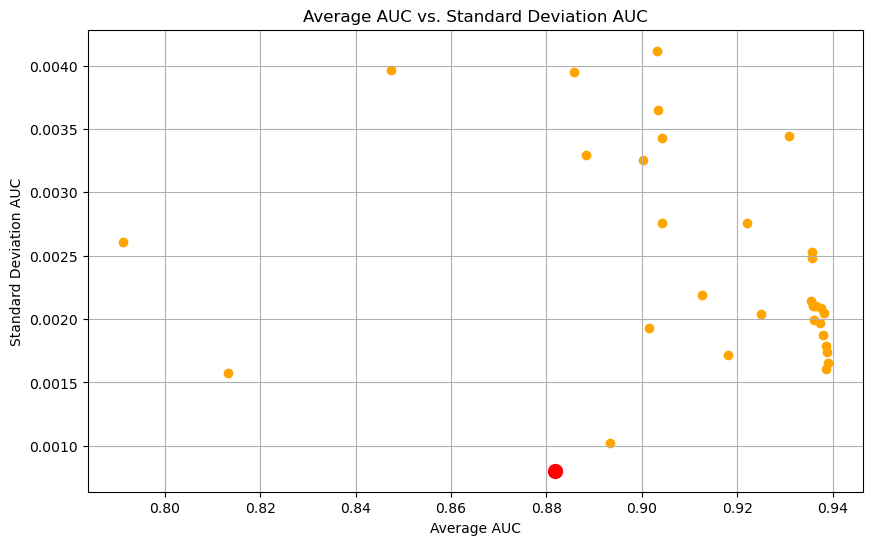

In [50]:
# Create a new column for the average AUC across all three samples and standard deviation of AUC across all three samples
nn_grid_search_result['Average AUC'] = nn_grid_search_result[['AUC_Train', 'AUC_Test1', 'AUC_Test2']].mean(axis=1)
nn_grid_search_result['Standard Deviation AUC'] = nn_grid_search_result[['AUC_Train', 'AUC_Test1', 'AUC_Test2']].std(axis=1)

# Create a scatter plot of average AUC and standard deviation AUC
plt.figure(figsize=(10, 6))
plt.scatter(nn_grid_search_result['Average AUC'], nn_grid_search_result['Standard Deviation AUC'], color='orange')
# Highlight the lowest standard deviation AUC
lowest_std_auc_index = nn_grid_search_result['Standard Deviation AUC'].idxmin()
plt.scatter(nn_grid_search_result.loc[lowest_std_auc_index, 'Average AUC'], nn_grid_search_result.loc[lowest_std_auc_index, 'Standard Deviation AUC'], color='red', s=100, label='Lowest Standard Deviation AUC')
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation AUC')
plt.title('Average AUC vs. Standard Deviation AUC')
plt.grid(True)
plt.show()

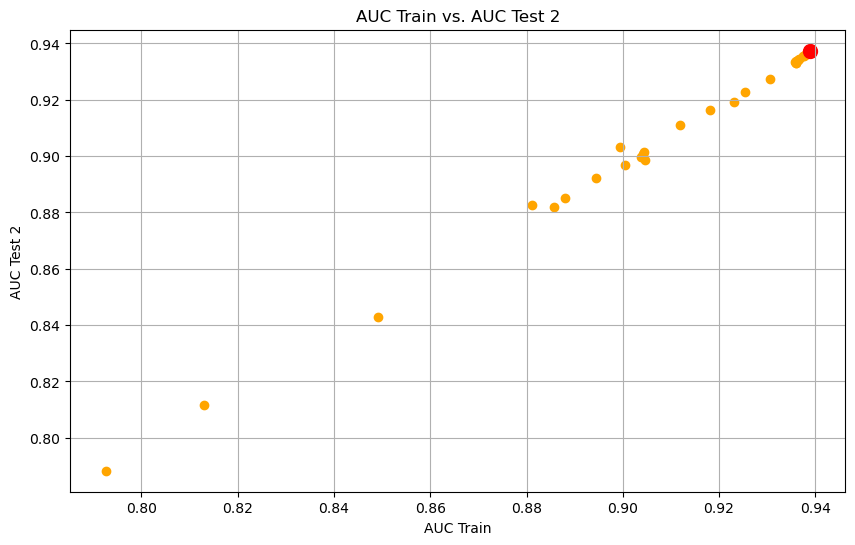

In [51]:
# Create a scatter plot of AUC Train and AUC Test 2
plt.figure(figsize=(10, 6))
plt.scatter(nn_grid_search_result['AUC_Train'], nn_grid_search_result['AUC_Test2'], color='orange')
# Highlight the highest AUC Test 2
highest_auc_test2_index = nn_grid_search_result['AUC_Test2'].idxmax()
plt.scatter(nn_grid_search_result.loc[highest_auc_test2_index, 'AUC_Train'], nn_grid_search_result.loc[highest_auc_test2_index, 'AUC_Test2'], color='red', s=100, label='Highest AUC Test 2')
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('AUC Train vs. AUC Test 2')
plt.grid(True)
plt.show()

In [52]:
nn_grid_search_result

,#HL,#Nodes,ActivationFunction,Dropout,BatchSize,AUC_Train,AUC_Test1,AUC_Test2,Average AUC,Standard Deviation AUC
0,2,4,relu,0.0,100,0.938030,0.939961,0.936207,0.938066,0.001877
1,2,4,relu,0.0,10000,0.899502,0.901711,0.903354,0.901523,0.001933
2,2,4,relu,0.5,100,0.936686,0.938521,0.934323,0.936510,0.002104
3,2,4,relu,0.5,10000,0.812889,0.814870,0.811759,0.813173,0.001575
4,2,4,tanh,0.0,100,0.937497,0.939370,0.935426,0.937431,0.001973
5,2,4,tanh,0.0,10000,0.792524,0.793077,0.788306,0.791302,0.002609
6,2,4,tanh,0.5,100,0.935965,0.938119,0.933083,0.935722,0.002527
7,2,4,tanh,0.5,10000,0.887881,0.891833,0.885297,0.888337,0.003292
8,2,6,relu,0.0,100,0.938893,0.940714,0.937412,0.939006,0.001654
9,2,6,relu,0.0,10000,0.904605,0.906329,0.898492,0.903142,0.004118


In [9]:
# STEP 13: Find the best parameters for NN
X_train_scaled = pd.read_csv('data/X_train_scaled.csv')
y_train = pd.read_csv('data/y_train.csv')
X_test1_scaled = pd.read_csv('data/X_test1_scaled.csv')
y_test1 = pd.read_csv('data/y_test1.csv')
X_test2_scaled = pd.read_csv('data/X_test2_scaled.csv')
y_test2 = pd.read_csv('data/y_test2.csv')

In [56]:
nn_grid_search_result.iloc[20]

#HL                              4
#Nodes                           4
ActivationFunction            tanh
Dropout                        0.0
BatchSize                      100
AUC_Train                 0.938362
AUC_Test1                 0.940211
AUC_Test2                 0.937016
Average AUC                0.93853
Standard Deviation AUC    0.001604
Name: 20, dtype: object

In [57]:
# Find the best parameters from row 20
best_parameters_nn = nn_grid_search_result.iloc[20]
best_model_nn = Sequential()
best_model_nn.add(Dense(int(best_parameters_nn['#Nodes']), input_dim=X_train_scaled.shape[1], activation=best_parameters_nn['ActivationFunction']))
best_model_nn.add(Dropout(best_parameters_nn['Dropout']))
for i in range(int(best_parameters_nn['#HL']) - 1):
    best_model_nn.add(Dense(int(best_parameters_nn['#Nodes']), activation=best_parameters_nn['ActivationFunction']))
    best_model_nn.add(Dropout(best_parameters_nn['Dropout']))
best_model_nn.add(Dense(1, activation='sigmoid'))
best_model_nn.compile(optimizer=Adam(), loss=BinaryCrossentropy())
best_model_nn.fit(X_train_scaled, y_train, batch_size=int(best_parameters_nn['BatchSize']), epochs=20)

Epoch 1/20


/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step - loss: 0.4844
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.2963
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 0.2840
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 0.2843
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 0.2803
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.2770
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 0.2772
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.2743
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 0.2751
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.2737
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 0.2721
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.2744
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 0.2743
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.2754
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

In [58]:
# Save the best model
best_model_nn.save('output/best_model_nn.keras')

In [3]:
# STEP 17 Strategy
def calculate_strategy_performance(data, target_col, model_output_col, balance_col, spend_col, threshold):
    accepted = data[data[model_output_col] < threshold]
    rejected = data[data[model_output_col] >= threshold]
    
    portfolio_default_rate = accepted[target_col].mean()
    
    accepted_defaulters = accepted[accepted[target_col] == 1]
    accepted_non_defaulters = accepted[accepted[target_col] == 0]
    
    defaulter_revenue = 0
    non_defaulter_revenue = accepted_non_defaulters[balance_col].mean() * 0.02 + accepted_non_defaulters[spend_col].mean() * 0.001
    non_defaulter_revenue *= 12  # For 12 months
    
    portfolio_revenue = non_defaulter_revenue * len(accepted_non_defaulters)
    
    return portfolio_default_rate, portfolio_revenue

In [59]:
X_train.columns

Index(['P_2_mean_12', 'P_2_mean_3', 'B_11_min_3', 'P_2_min_3', 'B_2_sum_3',
       'D_45_sum_12', 'B_9_mean_3', 'B_1_mean_3', 'R_1_mean_3', 'B_1_min_3',
       'B_18_sum_12', 'B_2_min_3'],
      dtype='object')

In [6]:
# Use B_5 and S_7 as balance and spend columns based on feature importance and SHAP analysis results
# Load original train data again
df_strategy = pd.read_csv('data/train_encoded_data.csv')
df_strategy = df_strategy[['B_5', 'S_7']]

,B_5,S_7
0,0.006477,0.395565
1,0.005730,0.370878
2,0.007920,0.376603
3,0.007378,0.374392
4,0.007687,0.387431
